In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import pickle
import warnings
from sklearn.metrics import accuracy_score

In [2]:
emails_df = pd.read_csv("data/emails.csv")
emails_df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [3]:
#print(emails_df['message'][8])
import re
def filter_fn(item):
    if item == '' or item == ' ':
        return False
    return True
def parse_email(item):
    findall = re.findall("From: .+.com\n", item)
    if len(findall) > 0:
        return findall[0].split(' ')[1].strip()
    else:
        return None
#print('\n'.join(list(filter(filter_fn, emails_df['message'][x].split('X-FileName:')[1].split('\n')))[1:]))
#emails_df['message'] = emails_df['message'].apply(lambda x: '\n'.join(list(filter(filter_fn, x.split('X-FileName:')[1].split('\n')))[1:]))
emails_df['source'] = emails_df['file'].apply(lambda x: x.split('/', 1)[0])
emails_df['source'].value_counts()[0:5]

kaminski-v    28465
dasovich-j    28234
kean-s        25351
mann-k        23381
jones-t       19950
Name: source, dtype: int64

In [4]:
top_five_sources = emails_df['source'].value_counts()[0:5].index.tolist() # Display top 5 email senders
emails_df = emails_df[emails_df['source'].isin(top_five_sources)].reset_index()
sources = emails_df['source'].unique()
source_dict = dict(zip(sources, range(len(sources))))
emails_df = emails_df.applymap(lambda s: source_dict.get(s) if s in source_dict else s)
emails_df['source_email'] = emails_df['message'].apply(lambda x: parse_email(x))
emails_df['source_email'].value_counts()[0:5]

kay.mann@enron.com          16658
vince.kaminski@enron.com    14335
jeff.dasovich@enron.com     10874
tana.jones@enron.com         7960
steven.kean@enron.com        6709
Name: source_email, dtype: int64

In [5]:
def remove_names(input_str, name_list):
    filename = '' if len(re.findall("(?<=X-FileName: )\w+\.[\w]{3}", input_str)) == 0 else re.findall("(?<=X-FileName: )\w+\.[\w]{3}", input_str)[0] 
    if filename is not '':
        input_str = input_str.split(filename)[-1]
    for name in name_list:
        input_str = input_str.replace(name[0], '')
        input_str = input_str.replace(name[1], '')
    return input_str
top_emails = emails_df['source_email'].value_counts()[0:5].index.tolist()
parsed_names = [(x.split('@')[0].split('.')[0].capitalize(), x.split('@')[0].split('.')[1].capitalize()) for x in top_emails]
#emails_df['message'] = emails_df['message'].apply(lambda x: remove_names(x, parsed_names))

In [6]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
NUM_TOP_WORDS = None
MAX_ART_LEN = 300 # maximum and minimum number of words

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(emails_df['message'])
sequences = tokenizer.texts_to_sequences(emails_df['message'])

C:\Users\mayam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y = emails_df['source']

print('Shape of data tensor:', X.shape)
#print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 455561 unique tokens. Distilled to 455561 top words.
Shape of data tensor: (125381, 300)
455555


In [9]:
from sklearn.model_selection import train_test_split
# Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                            stratify=emails_df['source'], 
                                                            random_state=42)
y_train_ohe = keras.utils.to_categorical(y_train)
y_test_ohe = keras.utils.to_categorical(y_test)
NUM_CLASSES = 5
print(X_train.shape,y_train_ohe.shape)
print(np.sum(y_train_ohe,axis=0))

(100304, 300) (100304, 5)
[22587. 15960. 22772. 20280. 18705.]


In [10]:
# show example without the FOR loop
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers.embeddings import Embedding


EMBED_SIZE = 50
rnns = []
input_holder = Input(shape=(X_train.shape[1], ))
input_embed = Embedding(top_words + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN)(input_holder) # number of words in each sequence


x = SimpleRNN(25,dropout=0.2, recurrent_dropout=0.2)(input_embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
rnn=Model(inputs=input_holder,outputs=x)
rnn.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

In [11]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers.embeddings import Embedding

EMBED_SIZE = 50
rnns = []
input_holder = Input(shape=(X_train.shape[1], ))
shared_embed = Embedding(top_words + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN)(input_holder) # number of words in each sequence

for func in [SimpleRNN, LSTM, GRU]:
    
    x = func(50, dropout=0.2, recurrent_dropout=0.2)(shared_embed)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    rnn=Model(inputs=input_holder,outputs=x)
    rnn.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
    rnns.append(rnn)

In [13]:
for rnn, name in zip(rnns,['simple','lstm','gru']):
    print('=======',name,'========')
    rnn.fit(X_train, y_train_ohe, epochs=3, batch_size=64, validation_data=(X_test, y_test_ohe))

======= simple ========
Train on 100304 samples, validate on 25077 samples
Epoch 1/3
100304/100304 [==============================] - 456s 5ms/step - loss: 0.3367 - acc: 0.8614 - val_loss: 0.2462 - val_acc: 0.8981
Epoch 2/3
100304/100304 [==============================] - 463s 5ms/step - loss: 0.2219 - acc: 0.9100 - val_loss: 0.1872 - val_acc: 0.9254
Epoch 3/3
100304/100304 [==============================] - 511s 5ms/step - loss: 0.1762 - acc: 0.9319 - val_loss: 0.1538 - val_acc: 0.9398
======= lstm ========
Train on 100304 samples, validate on 25077 samples
Epoch 1/3
100304/100304 [==============================] - 773s 8ms/step - loss: 0.1726 - acc: 0.9324 - val_loss: 0.0784 - val_acc: 0.9721
Epoch 2/3
100304/100304 [==============================] - 737s 7ms/step - loss: 0.0708 - acc: 0.9741 - val_loss: 0.0560 - val_acc: 0.9796
Epoch 3/3
100304/100304 [==============================] - 747s 7ms/step - loss: 0.0481 - acc: 0.9819 - val_loss: 0.0417 - val_acc: 0.9837
======= gru ======

In [14]:
for rnn, name in zip(rnns,['simple','lstm','gru']):
    print('Round 2 training,',name,'========')
    rnn.fit(X_train, y_train_ohe, epochs=3, batch_size=64, validation_data=(X_test, y_test_ohe))

Round 2 training, simple ========
Train on 100304 samples, validate on 25077 samples
Epoch 1/3
100304/100304 [==============================] - 461s 5ms/step - loss: 0.1639 - acc: 0.9378 - val_loss: 0.1249 - val_acc: 0.9549
Epoch 2/3
100304/100304 [==============================] - 465s 5ms/step - loss: 0.1285 - acc: 0.9533 - val_loss: 0.1092 - val_acc: 0.9619
Epoch 3/3
100304/100304 [==============================] - 471s 5ms/step - loss: 0.1142 - acc: 0.9594 - val_loss: 0.0995 - val_acc: 0.9657
Round 2 training, lstm ========
Train on 100304 samples, validate on 25077 samples
Epoch 1/3
100304/100304 [==============================] - 694s 7ms/step - loss: 0.0343 - acc: 0.9875 - val_loss: 0.0326 - val_acc: 0.9882
Epoch 2/3
100304/100304 [==============================] - 698s 7ms/step - loss: 0.0262 - acc: 0.9904 - val_loss: 0.0287 - val_acc: 0.9895
Epoch 3/3
100304/100304 [==============================] - 699s 7ms/step - loss: 0.0229 - acc: 0.9915 - val_loss: 0.0275 - val_acc: 0.990

Text(0.5,1,'RNN: 0.9762435947285554')

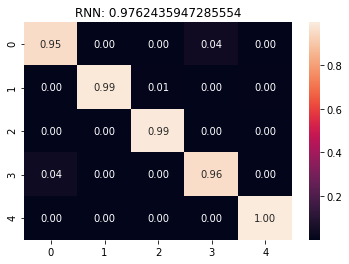

In [27]:
yhat_rnn = np.argmax(rnn.predict(X_test), axis=1)
f_rnn = mt.f1_score(y_test.values,yhat_rnn, average= 'weighted')
cm = mt.confusion_matrix(y_test.values,yhat_rnn)
cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
sns.heatmap(cm, annot=True, fmt='.2f')
plt.title('RNN: '+str(f_rnn))